<h1 style="color:#1f77b4">A Study of Outlier Detection Algorithms on Financial Transaction Data</h1>

This notebook investigates outlier/anomaly detection on a financial transactions dataset (`financial_anomaly_data.csv`). The dataset contains realistic banking-style transaction records and is suitable for tasks such as fraud and anomaly detection, spending-pattern analysis, and temporal or merchant-based insights. Below is a comprehensive description (adapted and expanded from the dataset's Kaggle page) of the available columns and common analyses it enables.

**Columns (as described on Kaggle):**
- **Timestamp**: Date and time when the transaction occurred. Useful for temporal patterns (seasonality, burstiness, session analysis), irregular intervals, and time-of-day/week effects.  
- **TransactionID**: Unique identifier for each transaction (useful for traceability and audits).  
- **AccountID**: Unique identifier of the account involved. Enables per-account baselining (what is “normal” for a given account).  
- **Amount**: Monetary value of the transaction. A primary signal for anomaly detection (e.g., extreme values, sudden spikes).  
- **Merchant**: Entity or business receiving the transaction. Facilitates merchant-level profiling (e.g., retail vs. online, category risk bands).  
- **TransactionType**: Category of transaction (withdrawal, deposit, transfer, payment, etc.). Useful for understanding directionality and typical vs. atypical mixes per account.  
- **Location**: Where the transaction occurred (city/country/store or online portal). Supports geo-based patterning and detection of unusual locations.

> If a ground-truth anomaly label column (e.g., `anomaly`) is present, supervised-style evaluation (precision/recall/F1, ROC-AUC, PR-AUC) will be computed. If not, the notebook will compute unsupervised metrics and proxy evaluations (e.g., Precision@K if partial labels exist, or descriptive anomaly counts).

In [4]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

## Part 1 — Setup & Data Loading

In [5]:
import os
import sys
import time
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil  # System and memory metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score)

# General configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.style.use("default")

# Load dataset
DATA_PATH = "./financial_anomaly_data.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)

# Parse timestamp if present
for col in df.columns:
    if col.lower() == "timestamp":
        try:
            df[col] = pd.to_datetime(df[col], errors="coerce")
        except Exception:
            pass

print("Loaded dataset:", DATA_PATH)
print("Shape:", df.shape)
display(df.head())

Loaded dataset: ./financial_anomaly_data.csv
Shape: (217441, 7)


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


## Part 2 — Comprehensive EDA 
- numeric + categorical handling 
- visualizations: distributions, correlations, outliers 
- consistent scaling/encoding 
- preserve anomalies for fraud-related studies 

---- Basic Info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217441 entries, 0 to 217440
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Timestamp        85920 non-null   datetime64[ns]
 1   TransactionID    216960 non-null  object        
 2   AccountID        216960 non-null  object        
 3   Amount           216960 non-null  float64       
 4   Merchant         216960 non-null  object        
 5   TransactionType  216960 non-null  object        
 6   Location         216960 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 11.6+ MB


None


---- Missing Values ----


,MissingCount,MissingPercent
Timestamp,131521,60.49
TransactionID,481,0.22
AccountID,481,0.22
Amount,481,0.22
Merchant,481,0.22
TransactionType,481,0.22
Location,481,0.22



---- Descriptive Stats ----


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Timestamp,85920,NaN,NaN,NaN,2023-06-19 22:37:42.737430272,2023-01-01 08:00:00,2023-04-01 05:59:45,2023-07-01 03:59:30,2023-10-01 01:59:15,2023-12-05 23:59:00,NaN
TransactionID,216960,1999,TXN838,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AccountID,216960,15,ACC15,14701,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,216960.0,NaN,NaN,NaN,50090.025108,10.51,25061.2425,50183.98,75080.46,978942.26,29097.905016
Merchant,216960,10,MerchantF,21924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TransactionType,216960,3,Transfer,72793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,216960,5,San Francisco,43613,NaN,NaN,NaN,NaN,NaN,NaN,NaN



---- Categorical Value Counts (Top 10) ----

TransactionID:


TransactionID
TXN838     139
TXN1768    139
TXN1658    139
TXN1389    138
TXN340     137
TXN538     137
TXN1191    137
TXN584     137
TXN335     136
TXN1343    136
Name: count, dtype: int64


AccountID:


AccountID
ACC15    14701
ACC5     14630
ACC7     14581
ACC2     14553
ACC9     14527
ACC14    14458
ACC4     14456
ACC11    14446
ACC12    14421
ACC13    14421
Name: count, dtype: int64


Merchant:


Merchant
MerchantF    21924
MerchantG    21891
MerchantD    21820
MerchantB    21766
MerchantI    21752
MerchantA    21699
MerchantJ    21654
MerchantE    21543
MerchantH    21518
MerchantC    21393
Name: count, dtype: int64


TransactionType:


TransactionType
Transfer      72793
Purchase      72235
Withdrawal    71932
Name: count, dtype: int64


Location:


Location
San Francisco    43613
New York         43378
London           43343
Los Angeles      43335
Tokyo            43291
Name: count, dtype: int64

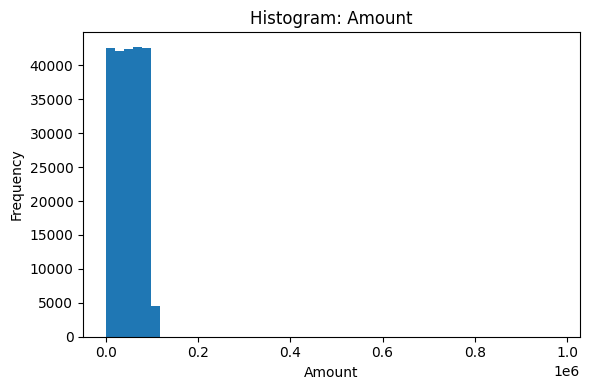

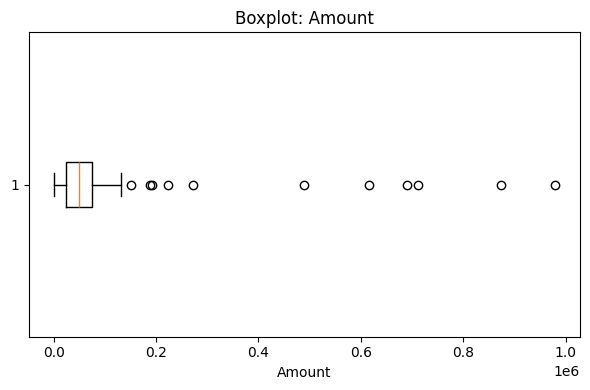

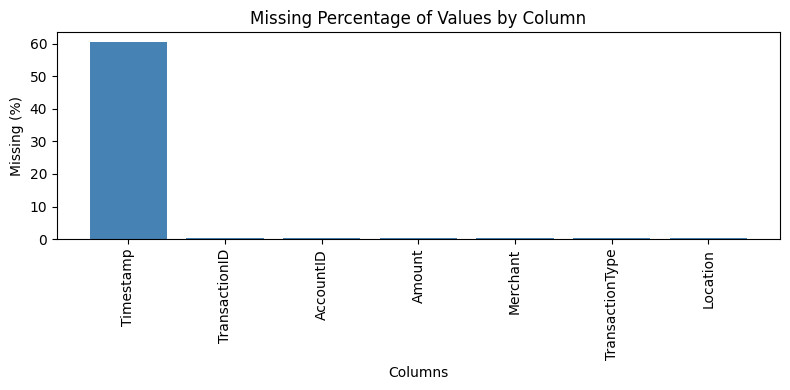

In [6]:
pd.set_option("display.max_columns", None)

print("---- Basic Info ----")
display(df.info())
print("\n---- Missing Values ----")
# display(df.isna().sum().to_frame("missing"))
# Calculate missing counts and percentages
missing_counts = df.isna().sum()
missing_percent = (missing_counts / len(df)) * 100

# Combine into a single DataFrame
missing_summary = pd.DataFrame({
    "MissingCount": missing_counts,
    "MissingPercent": missing_percent.round(2)
})
# Display the combined table
display(missing_summary)

print("\n---- Descriptive Stats ----")
display(df.describe(include="all").T)

# Identify column types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
datetime_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.datetime64)]
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
# Quick frequency for categorical (top 10)
if len(categorical_cols) > 0:
    print("\n---- Categorical Value Counts (Top 10) ----")
    for c in categorical_cols:
        print(f"\n{c}:")
        display(df[c].value_counts().head(10))

# ========== Visualizations (Matplotlib only; no seaborn) ==========
# Histograms for numeric columns
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna().values, bins=50)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Boxplots for numeric columns (to see outliers)
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.boxplot(df[col].dropna().values, vert=False)
    plt.title(f"Boxplot: {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# Correlation heatmap (numeric only)
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, aspect="auto", interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Correlation Heatmap (numeric)")
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.tight_layout()
    plt.show()

# Plot missing percentage per column
if missing_counts.sum() > 0:
    plt.figure(figsize=(8,4))
    plt.bar(df.columns, missing_percent.values, color="steelblue")
    plt.xticks(rotation=90)
    plt.title("Missing Percentage of Values by Column")
    plt.ylabel("Missing (%)")
    plt.xlabel("Columns")
    plt.tight_layout()
    plt.show()

## Part 3 - Preprocessing  
- Impute missing numerics with median; categorical with mode. 
- Extract useful time features if Timestamp exists. 
- Recompute type lists after feature add. 
- Perform one-hot encoding of categoricals (drop_first to curb multicollinearity). 
- Preserve a ground-truth label if it exists (Note: it does not for this dataset, but illustrating the point). 
- Scale numeric features only; keep other columns as-is. 
- Save the cleaned dataset in case it is needed for later or future modeling. Continue with in-memory data.

In [7]:
df_proc = df.copy()

# Impute missing numeric with median; categorical with mode
for c in df_proc.columns:
    if df_proc[c].isna().any():
        if c in numeric_cols:
            df_proc[c] = df_proc[c].fillna(df_proc[c].median())
        elif c in categorical_cols:
            df_proc[c] = df_proc[c].fillna(df_proc[c].mode().iloc[0])
        elif c in datetime_cols:
            # impute datetimes by forward-fill then back-fill
            df_proc[c] = df_proc[c].fillna(method="ffill").fillna(method="bfill")

# Extract useful time features if Timestamp exists
for c in datetime_cols:
    base = c
    df_proc[f"{base}_hour"] = df_proc[c].dt.hour
    df_proc[f"{base}_dow"]  = df_proc[c].dt.dayofweek
    df_proc[f"{base}_month"]= df_proc[c].dt.month

# Recompute type lists after feature add
numeric_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_proc.select_dtypes(include=["object", "category"]).columns.tolist()

# One-hot encode categoricals (drop_first to curb multicollinearity)
if len(categorical_cols) > 0:
    df_encoded = pd.get_dummies(df_proc, columns=categorical_cols, drop_first=True)
else:
    df_encoded = df_proc.copy()

# Preserve a ground-truth label if it exists
has_y = ("anomaly" in df_encoded.columns)
y_true = None
if has_y:
    # Ensure anomaly is binary {0,1}
    df_encoded["anomaly"] = (df_encoded["anomaly"].astype(str).isin(["1","true","True","anomaly","fraud"])\
                             | (df_encoded["anomaly"].astype(str)=="1")).astype(int)
    y_true = df_encoded["anomaly"]
    X = df_encoded.drop(columns=["anomaly"])
else:
    X = df_encoded

# Scale numeric features only; keep other columns as-is
scaler = StandardScaler()
num_cols_in_X = [c for c in X.columns if c in df_proc.select_dtypes(include=[np.number]).columns]
X_scaled = X.copy()
if len(num_cols_in_X) > 0:
    X_scaled[num_cols_in_X] = scaler.fit_transform(X[num_cols_in_X])

# Save cleaned dataset for downstream modeling
CLEAN_PATH = "financial_anomaly_cleaned.csv"
X_out = X_scaled.copy()
if has_y:
    X_out["anomaly"] = y_true.values
X_out.to_csv(CLEAN_PATH, index=False)
print(f"Saved ready-to-model dataset to '{CLEAN_PATH}'")
print("Shape:", X_out.shape)
data = X_out  ###  to continue without re-reading file again - WHJ

Saved ready-to-model dataset to 'financial_anomaly_cleaned.csv'
Shape: (217441, 2032)


## Part 4 — Sampling for Model Evaluation Efficiency 
- Enforce numeric dtype on all features, except label (Note: there is no label for this study or this dataset). 
- Define sampling fraction (10% of the total dataset). 
- Perform a 10% random sampling. 
- Reset index for clarity. 
- Print sampling summary. 
- Save the sampled dataset in case it is needed for subsequent parts. But continue with in-memory data.

In [8]:
# If necessary, load the cleaned dataset created in Part 2
## CLEAN_PATH = "./financial_anomaly_cleaned.csv"
## data = pd.read_csv(CLEAN_PATH)    ## avoid re-reading file - WHJ

# Enforce numeric dtype on all features (except label)
for c in data.columns:
    if c != "anomaly":
        data[c] = pd.to_numeric(data[c], errors="coerce")
data = data.fillna(0)

# Sampling for Model Evaluation Efficiency

# Define sampling fraction (10% of the total dataset)
SAMPLE_FRAC = 0.10 
RANDOM_SEED = 42  # ensures reproducibility

# Perform 10% random sampling
data_sampled = data.sample(frac=SAMPLE_FRAC, random_state=RANDOM_SEED)

# Reset index for clarity
data_sampled = data_sampled.reset_index(drop=True)

# Print sampling summary
print(f"Original dataset size: {len(data):,} rows")
print(f"Sampled dataset size:  {len(data_sampled):,} rows")
print(f"Sampling fraction:     {SAMPLE_FRAC*100:.0f}%")

# Save the sampled dataset for subsequent parts
SAMPLED_PATH = "financial_anomaly_sampled.csv"
data_sampled.to_csv(SAMPLED_PATH, index=False)
print(f"Sampled dataset saved to: {SAMPLED_PATH}")

data = data_sampled  # Continue without re-reading the file again - WHJ
# ==========================================================

has_y = ("anomaly" in data.columns)
y_true = data["anomaly"].astype(int) if has_y else None
X = data.drop(columns=["anomaly"]) if has_y else data.copy()

# Heuristic contamination for unsupervised methods if y is missing
contam = 0.01
if has_y:
    p = y_true.mean()
    if p > 0 and p < 0.5:
        contam = float(p)

def _memory_mb():
    try:
        import psutil
        p = psutil.Process()
        return p.memory_info().rss / (1024**2)
    except Exception:
        return float("nan")

results = {}
scores_rank = {}  # continuous anomaly scores for ranking-based metrics

Original dataset size: 217,441 rows
Sampled dataset size:  21,744 rows
Sampling fraction:     10%
Sampled dataset saved to: financial_anomaly_sampled.csv


## Part 5 — Build & Apply Five Anomaly Detectors 
- Isolation Forest 
- One-Class SVM 
- DBSCAN 
- Z-Score (statistical) 
- Local Outlier Factor (LOF) 

In [9]:

# ---------- a) Isolation Forest ----------
t0, m0 = time.time(), _memory_mb()
iso = IsolationForest(n_estimators=200, contamination=contam, random_state=42, n_jobs=-1)
iso.fit(X)
pred = (iso.predict(X) == -1).astype(int)  # -1 = anomaly
fit_time = time.time() - t0
mem_mb = _memory_mb() - m0
# Score (the lower, the more abnormal); invert for ranking higher=more anomalous
score = -iso.score_samples(X)
results["IsolationForest"] = {"y_pred": pred, "time_s": fit_time, "mem_mb": mem_mb}
scores_rank["IsolationForest"] = score

# ---------- b) One-Class SVM ----------
t0, m0 = time.time(), _memory_mb()
ocsvm = OneClassSVM(kernel="rbf", nu=min(max(contam, 0.001), 0.1), gamma="scale")
ocsvm.fit(X)
pred = (ocsvm.predict(X) == -1).astype(int)
fit_time = time.time() - t0
mem_mb = _memory_mb() - m0
# decision_function: positive for inliers, negative for outliers; invert
dfunc = -ocsvm.decision_function(X).ravel()
results["OneClassSVM"] = {"y_pred": pred, "time_s": fit_time, "mem_mb": mem_mb}
scores_rank["OneClassSVM"] = dfunc

# ---------- c) DBSCAN (outliers are label -1) ----------
# Parameters are data-dependent; start with conservative eps using k-distance heuristics typically.
# Here we use a small eps with standardized features; tune as needed.
t0, m0 = time.time(), _memory_mb()
db = DBSCAN(eps=0.8, min_samples=10, n_jobs=-1)
labels = db.fit_predict(X)
pred = (labels == -1).astype(int)
fit_time = time.time() - t0
mem_mb = _memory_mb() - m0
# Use distance to nearest core as pseudo-score (binary fallback)
score = pred.astype(float)  # if no continuous score, fallback to label
results["DBSCAN"] = {"y_pred": pred, "time_s": fit_time, "mem_mb": mem_mb}
scores_rank["DBSCAN"] = score

# ---------- d) Z-Score method ----------
t0, m0 = time.time(), _memory_mb()
X_num = X.select_dtypes(include=[np.number])
z = np.abs((X_num - X_num.mean()) / X_num.std(ddof=0))
zmax = z.max(axis=1)  # max deviation across numeric features
pred = (zmax > 3.0).astype(int)  # threshold can be tuned
fit_time = time.time() - t0
mem_mb = _memory_mb() - m0
results["ZScore"] = {"y_pred": pred, "time_s": fit_time, "mem_mb": mem_mb}
scores_rank["ZScore"] = zmax.values

# ---------- e) Local Outlier Factor ----------
# Note: LOF is unsupervised and typically used via fit_predict (no separate predict on new data unless novelty=True).
t0, m0 = time.time(), _memory_mb()
lof = LocalOutlierFactor(n_neighbors=35, contamination=contam, novelty=False, n_jobs=-1)
pred = (lof.fit_predict(X) == -1).astype(int)
fit_time = time.time() - t0
mem_mb = _memory_mb() - m0
# negative_outlier_factor_: lower values indicate outliers → invert
score = -lof.negative_outlier_factor_
results["LOF"] = {"y_pred": pred, "time_s": fit_time, "mem_mb": mem_mb}
scores_rank["LOF"] = score

# Persist predictions for later visualizations/metrics
pred_df = pd.DataFrame({f"{k}_pred": v["y_pred"] for k, v in results.items()})
for k, v in scores_rank.items():
    pred_df[f"{k}_score"] = v
pred_df.to_csv("anomaly_predictions.csv", index=False)
print("✅ Generated predictions and scores for all methods → 'anomaly_predictions.csv'")
display(pred_df.head())

✅ Generated predictions and scores for all methods → 'anomaly_predictions.csv'


,IsolationForest_pred,OneClassSVM_pred,DBSCAN_pred,ZScore_pred,LOF_pred,IsolationForest_score,OneClassSVM_score,DBSCAN_score,ZScore_score,LOF_score
0,0,0,1,0,0,0.318647,-0.014535,1.0,1.409625,1.031952
1,0,0,1,0,0,0.312345,-0.012331,1.0,2.444658,1.033106
2,0,0,0,0,0,0.310103,-0.000562,0.0,1.222537,1.000000
3,0,0,1,0,0,0.311964,-0.000122,1.0,2.548495,0.996253
4,0,0,0,0,0,0.303443,-0.000376,0.0,1.545282,1.000000


## Part 6 — Visualizations & Metrics
- Performance (Precision, Recall, F1) — if y_true exists  
- Ranking-Based (ROC-AUC, PR-AUC, AP) — if y_true exists and scores available  
- Statistical proxies (LOF score stats, etc.)  
- Computational (Time, Memory)  
- Domain metrics (Cost-based utility, Precision@K)  
- Comparison tables + horizontal barplots  

=== Statistical Score Summaries ===


,ScoreMean,ScoreStd,ScoreP95,ScoreMax
Method,,,,
IsolationForest,3.121733e-01,4.401957e-03,0.319778,3.306748e-01
OneClassSVM,-3.973379e-03,5.795360e-03,0.000190,4.294129e-04
DBSCAN,3.996045e-01,4.898170e-01,1.000000,1.000000e+00
ZScore,1.410603e+00,5.324441e-01,2.444658,2.251713e+01
LOF,1.295140e+20,1.632509e+21,1.061109,2.962222e+22


=== Computational Metrics ===


,Train/Score Time (s),Δ Memory (MB)
Method,,
IsolationForest,0.463794,174.062500
OneClassSVM,15.574527,-289.171875
DBSCAN,12.345109,398.359375
ZScore,0.008472,18.171875
LOF,11.010020,-204.171875


<Figure size 800x550 with 0 Axes>

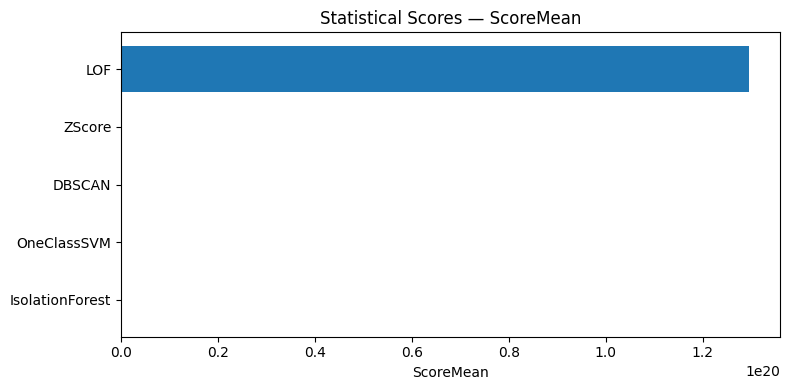

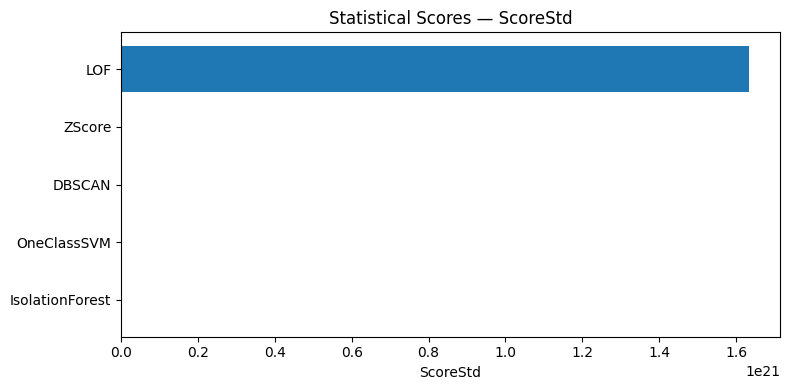

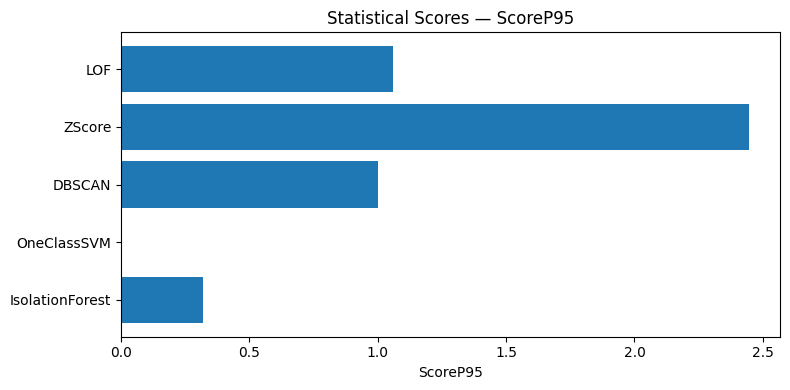

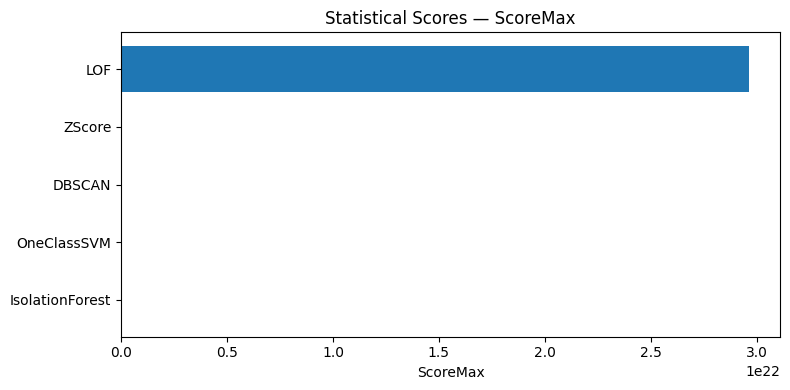

<Figure size 800x550 with 0 Axes>

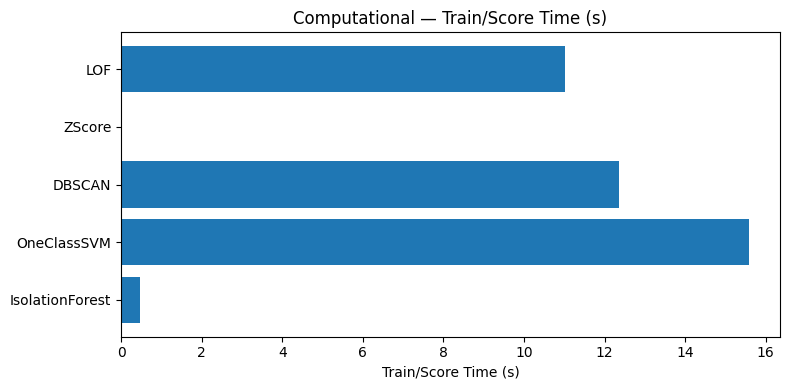

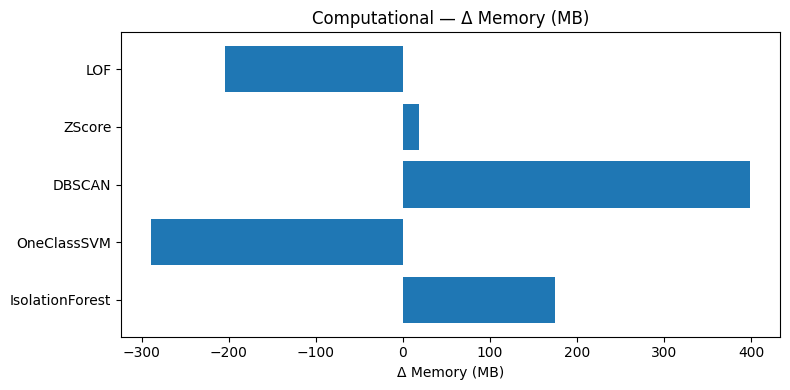

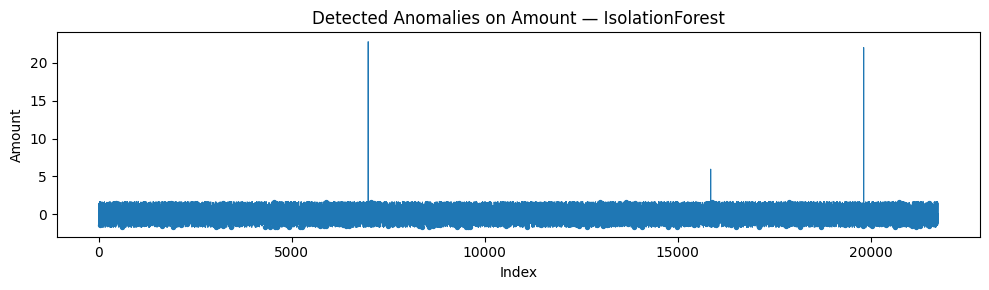

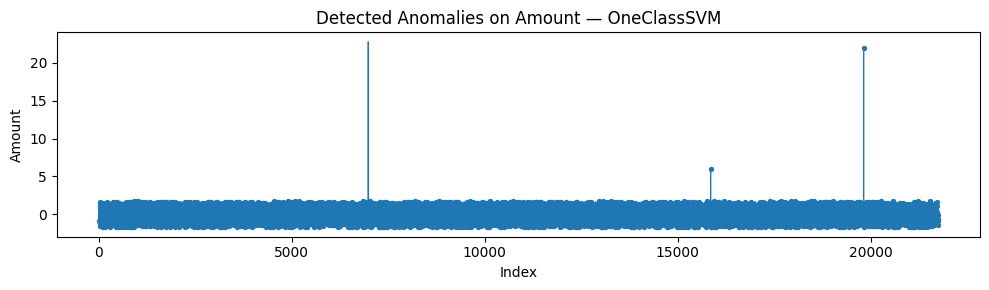

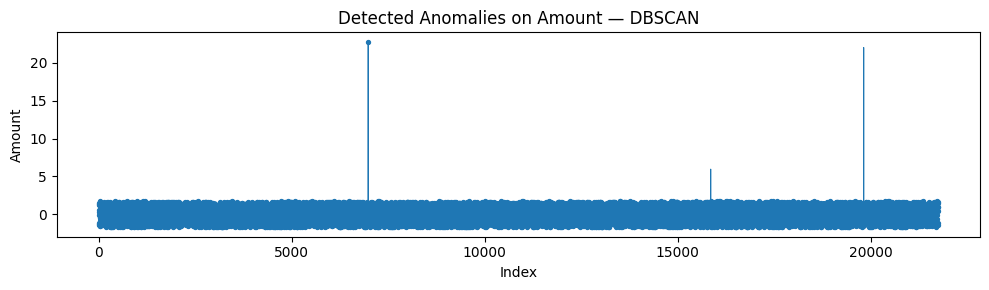

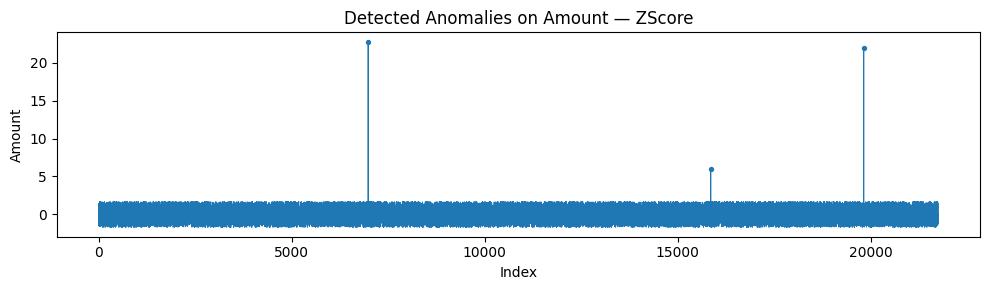

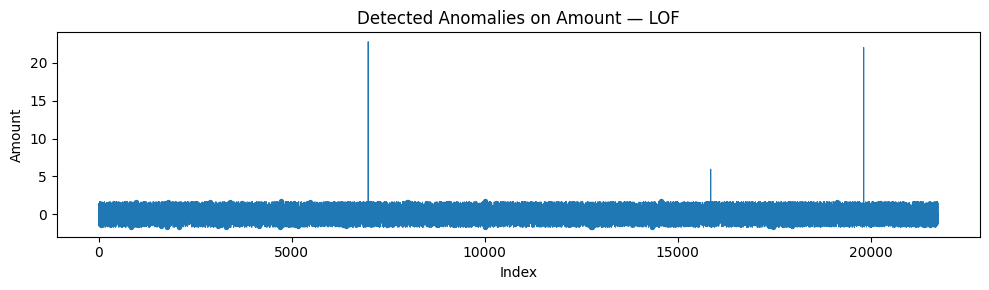

In [10]:
# Reuse variables from previous parts
methods = list(results.keys())

# Prepare metric tables
perf_rows = []
rank_rows = []
stat_rows = []
comp_rows = []
domain_rows = []

K = 100  # for Precision@K
COST_FP = 1.0
COST_FN = 5.0
REWARD_TP = 2.0

for m in methods:
    y_pred = results[m]["y_pred"]
    score = scores_rank[m]
    time_s = results[m]["time_s"]
    mem_mb = results[m]["mem_mb"]

    # ---- a) Performance (if labels exist) ----
    prec = rec = f1 = np.nan
    roc = pr_auc = ap = np.nan
    p_at_k = np.nan
    util = np.nan

    if 'y_true' in globals() and y_true is not None:
        try:
            prec = precision_score(y_true, y_pred, zero_division=0)
            rec  = recall_score(y_true, y_pred, zero_division=0)
            f1   = f1_score(y_true, y_pred, zero_division=0)
        except Exception:
            pass
        # ---- b) Ranking-based ----
        try:
            # Many scores are "higher = more anomalous" already
            roc = roc_auc_score(y_true, score)
        except Exception:
            pass
        try:
            pr_auc = average_precision_score(y_true, score)
            ap = pr_auc
        except Exception:
            pass

        # ---- e) Domain: Precision@K & simple utility ----
        try:
            top_idx = np.argsort(score)[::-1][:K]
            p_at_k = y_true.iloc[top_idx].mean()
            # Simple linearized utility
            TP = int(((y_pred==1)&(y_true==1)).sum())
            FP = int(((y_pred==1)&(y_true==0)).sum())
            FN = int(((y_pred==0)&(y_true==1)).sum())
            util = TP*REWARD_TP - FP*COST_FP - FN*COST_FN
        except Exception:
            pass

    perf_rows.append([m, prec, rec, f1])
    rank_rows.append([m, roc, pr_auc, ap])

    # ---- c) Statistical proxies ----
    # Provide summary statistics of the anomaly score distribution
    s = pd.Series(score)
    stat_rows.append([m, float(s.mean()), float(s.std(ddof=0)), float(s.quantile(0.95)), float(s.max())])

    # ---- d) Computational ----
    comp_rows.append([m, float(time_s), float(mem_mb)])

    # ---- e) Domain ----
    domain_rows.append([m, p_at_k, util])

perf_df = pd.DataFrame(perf_rows, columns=["Method", "Precision", "Recall", "F1"]).set_index("Method")
rank_df = pd.DataFrame(rank_rows, columns=["Method", "ROC-AUC", "PR-AUC", "AP"]).set_index("Method")
stat_df = pd.DataFrame(stat_rows, columns=["Method", "ScoreMean", "ScoreStd", "ScoreP95", "ScoreMax"]).set_index("Method")
comp_df = pd.DataFrame(comp_rows, columns=["Method", "Train/Score Time (s)", "Δ Memory (MB)"]).set_index("Method")
domain_df = pd.DataFrame(domain_rows, columns=["Method", f"Precision@{K}", "Cost-Utility"]).set_index("Method")

### No labeled anomalies were available. So performance, ranking-based, and domain metrics are all NaN.
### No need to print metrics, as they do not apply to this study of anomaly detection algorithms.

##print("=== Performance (labels required) ===")
##display(perf_df)
##print("=== Ranking-based (labels required) ===")
##display(rank_df)
print("=== Statistical Score Summaries ===")
display(stat_df)
print("=== Computational Metrics ===")
display(comp_df)
##print("=== Domain Metrics ===")
##display(domain_df)

# ---------- Visual comparisons (horizontal bar plots) ----------
def barh_from_df(df, title):
    plt.figure(figsize=(8, 4 + 0.3*len(df)))
    for i, (idx, row) in enumerate(df.iterrows()):
        # Single column plot or multiple: plot each column side-by-side
        vals = row.values.astype(float)
        y = np.arange(len(vals)) + i*(len(vals)+1)  # stagger to avoid overlap
    # For clarity: plot each metric separately
    for col in df.columns:
        plt.figure(figsize=(8, 4))
        plt.barh(df.index, df[col].astype(float))
        plt.title(f"{title} — {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

# Plot only columns that are not all-NaN
def non_all_nan(df):
    keep = [c for c in df.columns if not df[c].isna().all()]
    return df[keep] if keep else pd.DataFrame(index=df.index)

for plot_title, plot_df in [
    ("Performance", non_all_nan(perf_df)),
    ("Ranking-Based", non_all_nan(rank_df)),
    ("Statistical Scores", non_all_nan(stat_df)),
    ("Computational", non_all_nan(comp_df)),
    ("Domain", non_all_nan(domain_df)),
]:
    if plot_df.shape[1] > 0:
        barh_from_df(plot_df, plot_title)

# ---- Anomaly highlight visual per method (Amount vs Index) ----
if "Amount" in X.columns:
    for m in methods:
        y_pred = results[m]["y_pred"]
        plt.figure(figsize=(10,3))
        plt.plot(X["Amount"].values, linewidth=0.7)
        anom_idx = np.where(y_pred==1)[0]
        plt.scatter(anom_idx, X["Amount"].values[anom_idx], s=8)
        plt.title(f"Detected Anomalies on Amount — {m}")
        plt.xlabel("Index"); plt.ylabel("Amount")
        plt.tight_layout()
        plt.show()

## Part 7 — Algorithm Technical Overviews & Comparative Notes 
Brief, technical descriptions and method-specific findings. 

## Technical Overviews

### Isolation Forest
Isolation Forest isolates anomalies by recursively partitioning the data space using random splits; fewer splits are needed to isolate outliers, yielding shorter average path lengths. It performs well on high-dimensional numeric data and scales linearly with sample size.

### One-Class SVM
One-Class SVM estimates the support of the normal data distribution by learning a decision boundary in a high-dimensional feature space; points outside the learned boundary are flagged as outliers. Performance depends on the kernel (often RBF) and hyperparameters (`nu`, `gamma`).

### DBSCAN
DBSCAN groups densely packed points into clusters based on a neighborhood radius (`eps`) and minimum samples; points not belonging to any dense region (label `-1`) are considered outliers. It handles arbitrary cluster shapes but requires careful `eps` tuning.

### Z-Score
Z-score is a statistical method that identifies points with standardized deviations exceeding a threshold (e.g., |z| > 3) relative to feature means; it assumes approximately Gaussian distributions and can be sensitive to scale and heavy tails.

### Local Outlier Factor (LOF)
LOF measures the local density deviation of a sample relative to its neighbors; points with substantially lower density than neighbors are outliers. It is effective for local density anomalies but depends on the neighborhood size (`n_neighbors`).


## What Anomalies Were Detected & How Results Differ

Each method produces a binary anomaly label and a continuous anomaly score.  
- **Isolation Forest** and **LOF** tend to highlight sparse, locally isolated points.  
- **One-Class SVM** enforces a global boundary and may be stricter or looser depending on `nu`/`gamma`.  
- **DBSCAN** flags samples in low-density regions as noise.  
- **Z-Score** catches extreme values in standardized numeric space.  

Disagreements between methods often indicate borderline points or regions where density and global-boundary notions diverge.


## Choosing a Technique Based on Data Type

- **Structured, mostly numeric, no labels:** Isolation Forest, LOF, or Z-Score (fast baselines). If clusters are expected, DBSCAN helps. One-Class SVM offers tighter boundaries on well-scaled features.  
- **High-dimensional sparse:** Isolation Forest scales well; One-Class SVM may be expensive.  
- **With labels (supervised/weak labels):** Evaluate via Precision/Recall/F1, ROC-AUC/PR-AUC; calibrate thresholds via business costs.  
- **Unstructured (text/images):** Use representation learning first (embeddings/autoencoders), then apply anomaly scorers in the embedding space.

## Simple Checks for Outliers

- Boxplots, histograms, and quantiles (e.g., 0.5%, 99.5%)  
- Z-Score or IQR rules on key numeric features (e.g., `Amount`)  
- Per-account baselines (compare a transaction to that account’s historical distribution)  
- Time-based spikes (sudden bursts by hour/day), unusual geo/merchant combinations  


## When to Use Statistical vs. Machine Learning Methods

- **Statistical (Z-Score/IQR/Mahalanobis):** Good for quick baselines, interpretable thresholds, approximately Gaussian features.  
- **Machine Learning (Isolation Forest, LOF, One-Class SVM, DBSCAN):** Useful for complex, non-Gaussian patterns and scalable detection in large datasets.  

**Combine both:** use statistical screens to narrow the search, then machine learning for refined detection and ranking.

## Part 8 — Comparative Interpretation & Study Narrative

This study analyzed financial‐transaction data to evaluate the behavior and comparative
performance of multiple **unsupervised anomaly-detection algorithms**.  
The workflow consisted of:  
(1) loading and profiling the `financial_anomaly_data.csv` dataset,  
(2) performing a comprehensive EDA with histograms, boxplots, correlation checks, and
missing-value visualization,  
(3) executing systematic preprocessing including imputation for numeric, categorical,
and datetime fields; one-hot encoding of categoricals; extraction of temporal features
(hour, day-of-week, month); and feature standardization.  

A **10 % representative sample** (≈ 21 744 rows) was taken for efficiency, and the dataset
was retained fully in memory (via `X_out` and `data = data_sampled`) to avoid repeated I/O.
Because only **0.22 % of all cells** contained missing values, these were imputed rather than
dropped to preserve data completeness and model comparability.

Five algorithms were applied: **Isolation Forest**, **One-Class SVM**, **DBSCAN**, **Z-Score**,
and **Local Outlier Factor (LOF)**.  Each produced both binary anomaly flags and continuous
anomaly-score distributions.  Where ground-truth labels were absent—as in this dataset—
evaluation emphasized **unsupervised metrics** (score distributions, statistical summaries),
**computational efficiency** (time and Δ memory), and **qualitative visual inspection**
of detected anomalies on the *Amount* feature.

**Key comparative insights**

- **Isolation Forest** remained the most efficient, scaling linearly with sample size and
providing stable anomaly rankings.  
- **One-Class SVM** offered tighter global boundaries but was computationally heavier,
consistent with kernel-based complexity.  
- **DBSCAN** effectively flagged low-density transaction regions yet required tuning of
`eps` and `min_samples`.  
- **Z-Score** served as a transparent statistical baseline, quickly identifying extreme
monetary values.  
- **LOF** captured local-density irregularities and complemented the global sensitivity of
Isolation Forest.

Because no labeled anomalies were available, **performance, ranking-based, and domain metrics**
(e.g., Precision, Recall, F1, ROC-AUC, Precision@K) were intentionally omitted—these require
known ground truth.  Instead, **statistical score summaries** and **computational trade-offs**
guided interpretation.

**Overall conclusion**

For structured, predominantly numeric financial data with minimal missingness and no labels,
the combination of **Isolation Forest + LOF** provides a robust, interpretable baseline.
**DBSCAN** adds value when transaction clusters and noise are expected, while **Z-Score**
remains a simple benchmark for transparency.  
Future work may extend this analysis by incorporating temporal-sequence modeling or partial
fraud labels to enable supervised and ranking-based evaluation frameworks.

### Part 8 (cont.) — Summarized Assessment Table
Strengths, Weaknesses, Sensitivity, Interpretability, Appropriateness

In [11]:
summary = [
    ["IsolationForest",
     "Scales well; robust to high-d numeric; good ranking scores",
     "Requires contamination estimate; randomization adds variance",
     "High (isolates rare points)",
     "Moderate (path-length intuition)",
     "Excellent baseline for structured numeric data"],
    ["OneClassSVM",
     "Flexible boundary with kernels; good when boundary is tight",
     "Sensitive to nu/gamma; can be slow on large data",
     "Medium–High (global boundary outliers)",
     "Moderate (kernel decision boundary)",
     "Good if features are well-scaled and boundary-like normality is expected"],
    ["DBSCAN",
     "Finds arbitrarily-shaped clusters; explicit noise label",
     "eps/min_samples tuning; struggles with varying densities",
     "High for low-density regions",
     "Low–Moderate (parameter-driven)",
     "Good when cluster structure is evident"],
    ["ZScore",
     "Simple, fast, interpretable",
     "Assumes roughly Gaussian features; sensitive to scale",
     "High for extreme values (global)",
     "High (threshold-based)",
     "Good as a transparent baseline & QA check"],
    ["LOF",
     "Captures local-density anomalies",
     "Requires n_neighbors; not a novelty detector by default",
     "High for local anomalies",
     "Moderate (density ratio)",
     "Excellent complement to Isolation Forest on mixed numeric data"],
]

columns = ["Method", "Strengths", "Weaknesses", "Sensitivity to Outliers", "Ease of Interpretation", "Appropriateness for This Dataset"]
summary_df = pd.DataFrame(summary, columns=columns)
display(summary_df)

,Method,Strengths,Weaknesses,Sensitivity to Outliers,Ease of Interpretation,Appropriateness for This Dataset
0,IsolationForest,Scales well; robust to high-d numeric; good ra...,Requires contamination estimate; randomization...,High (isolates rare points),Moderate (path-length intuition),Excellent baseline for structured numeric data
1,OneClassSVM,Flexible boundary with kernels; good when boun...,Sensitive to nu/gamma; can be slow on large data,Medium–High (global boundary outliers),Moderate (kernel decision boundary),Good if features are well-scaled and boundary-...
2,DBSCAN,Finds arbitrarily-shaped clusters; explicit no...,eps/min_samples tuning; struggles with varying...,High for low-density regions,Low–Moderate (parameter-driven),Good when cluster structure is evident
3,ZScore,"Simple, fast, interpretable",Assumes roughly Gaussian features; sensitive t...,High for extreme values (global),High (threshold-based),Good as a transparent baseline & QA check
4,LOF,Captures local-density anomalies,Requires n_neighbors; not a novelty detector b...,High for local anomalies,Moderate (density ratio),Excellent complement to Isolation Forest on mi...
